### Klärung der Aufgabenstellung

1. Ziel der Untersuchung ist es, die folgenden Fragen zu beantworten:

    a) Kriegt die Persion einen Schlaganfall?

    b) Wie hoch ist die Wahrscheinlichkeit, dass die Person einen Schlaganfall kriegt?

2. Arbeits-Hypothese vor Beginn der Untersuchung

3. Qualitätskriterien (Welche Sorte Score?, Wie hoch muss er am Ende sein?)

4. Welche Sorte von Machine Learning-Verfahren?

    Random Forest



5. Roadmap für die einzelnen Untersuchungsdurchgänge

    a) Data Understanding

    b) Data Preparation

    c) Data Modelling

    d) Model evaluation


In [4]:

# klassische imports
import pandas as pd
import numpy as np

# fürs plotten (matplotlib reicht nicht immer)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

# für modelle mit knn
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

# normalverteilung prüfen
from scipy.stats import shapiro


In [5]:
#Laden von dem Dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# daten checken
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Data Overview")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 1528.21it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1. Data Understanding

In [7]:
#Anschauen von den ersten 5 Zeilen
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
#Anschauen von der Anzahl von Zeilen und Spalten
df.shape

(5110, 12)

In [11]:

# Überblick über Typen, Nullwerte, etc.
print(df.info())

# Statistik über alle Spalten (auch Strings)
print(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
                  id  gender          age  hypertension  heart_disease  \
count    5110.000000    5110  5110.000000   5110.000000    5110.000000   
uniq

In [12]:
# Entferne Zeilen, bei denen der Geschlechtswert "Other" ist.
df = df[df['gender'] != "Other"]

In [13]:
#Anzeige von der Zielspalte "Stroke"
df.stroke.value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

### 2. Data Preparation
Erkundung von fehlenden Werten

In [14]:
#Prozentsatz der fehlenden Werte (NAs)
# --> Es fehlen 4% der BMI Werte, wie sollen diese am besten imputet werden?
df.isnull().sum()*100/len(df)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.934234
smoking_status       0.000000
stroke               0.000000
dtype: float64

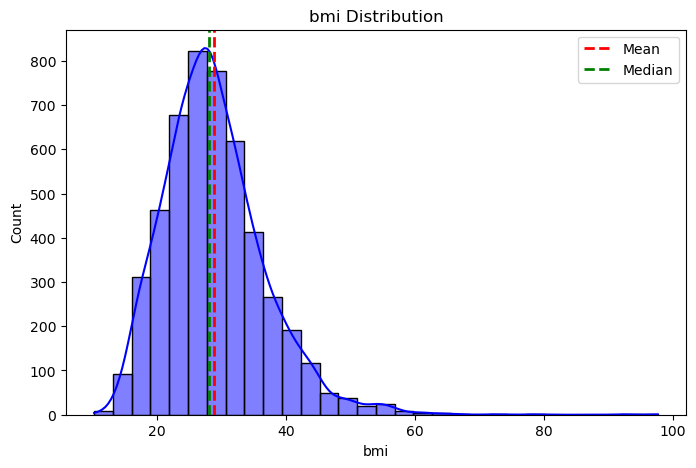

In [17]:
# Histogram für die Verteilung der Variable des Alters
%matplotlib inline

plt.figure(figsize=(8, 5))
sns.histplot(df['bmi'], bins=30, kde=True, color='blue')
plt.axvline(df['bmi'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(df['bmi'].median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.legend()
plt.title('bmi Distribution')
plt.show()

In [18]:
#Shapiro-Test um zu prüfen, ob BMI-Werte normal verteilt sind
bmi = df["bmi"].dropna()
statistic, p_value = shapiro(bmi)
print(f"Shapiro-Wilk Test Statistic: {statistic}")
print(f"P-value: {p_value}")

Shapiro-Wilk Test Statistic: 0.9535668072385075
P-value: 6.759071773727945e-37


In [19]:
#Erkundung von der Spalte Smoking Status
#hier wurde festgestellt, dass bei 30% der Daten der Raucherstatus nicht bekannt ist, was für die zukünftige Analyse schlecht ist
#die fehlenden Daten bei BMI und Smoking Status - Unknown müssen aufgefüllt werden.
df.smoking_status.unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [20]:
count = (df["smoking_status"] == 'Unknown').sum()/df.shape[0]*100
print(count)

30.221178312781365


#### Erkundung der fehlenden Werten

In [21]:
#Erstellung einer neuen Variable 'Age Group', um Benutzer nach Alter zu kategorisieren
bins = [0, 18, 25, 35, 45, 55, 65, 110]
labels = ['<18','18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_mit_age_group = df.copy(deep = True)
df_mit_age_group['Age Group'] = pd.cut(df["age"], bins, labels = labels,include_lowest = True)

In [22]:
#Prüfen ob die neue Spalte erfolgreich erstellt wurde
df_mit_age_group.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Age Group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65+
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,55-64
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,65+
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,45-54
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,65+


In [ ]:
#Plotten der Verteilung von Altersgruppen nach Raucherstatus
#es wurde festgestellt, dass es die Mehrheit von den fehlenden Werten bei Raucherstatus bei den Mindejährigen gibt
#dadurch sind wir zur logischen Schlussfolgerung gekommen, dass bei den Miderjährigen wahrscheinlich gar keinen Daten
#zum Raucherstatus erfasst wurden. 
sns.countplot(x = "Age Group", hue  = "smoking_status", data = df_mit_age_group)

<Axes: xlabel='Age Group', ylabel='count'>

In [25]:
#Wie viele Menschen unter 18 hatten einen Schlaganfall?
# --> nur einer, der 1 Jahr alt ist und einer der 14 Jahre alt gewesen ist
# --> Annahme: Die Ursache war definitiv nicht das Rauchen und daher wird der "smoking_status" = "never smoked" gesetzt
print(df.loc[(df['age'] < 18) & (df['stroke'] == 1), ['age', 'smoking_status']])

       age smoking_status
162   1.32        Unknown
245  14.00        Unknown


In [26]:
#Erstellen einer Kopie des original Datensatzes, in denen die Daten manipuliert werden (BMI, Smoking status, ID)
df_upd = df.copy(deep = True)

In [27]:
#Bei allen Menschen, die junger als 18 Jahre alt sind und bei den Raucherstatus nicht bekannt ist, wird der Raucherstatus zu "never_smoked" gesetzt
df_upd.loc[(df_upd["smoking_status"] == "Unknown") & (df_upd["age"] < 18), "smoking_status"] = "never smoked"
#ID wird gedroppt aus der Analyse --> keine Aussagekraft
df_upd = df_upd.drop(columns=['id'])

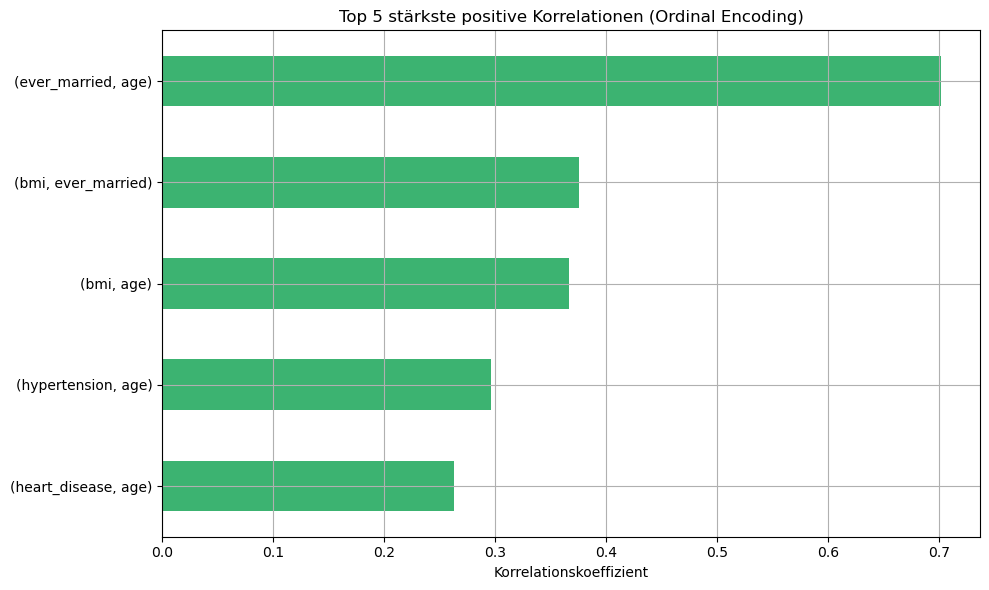


Top 5 stärkste positive Korrelationen:
ever_married   age             0.701415
bmi            ever_married    0.375832
               age             0.366588
hypertension   age             0.296607
heart_disease  age             0.262428
dtype: float64


In [29]:
# 1. DataFrame vorbereiten: keine 'Unknown'
%matplotlib inline

df_corr_ord = df_upd[df_upd['smoking_status'] != 'Unknown'].copy()

# 2. Kategoriale Spalten identifizieren und mit OrdinalEncoder transformieren
categorical_cols = df_corr_ord.select_dtypes(include=['object']).columns
oe = OrdinalEncoder()
df_corr_ord[categorical_cols] = oe.fit_transform(df_corr_ord[categorical_cols].astype(str))

# 3. Optional: Skalieren (empfohlen für KNN oder Vergleiche)
scaler = MinMaxScaler()
df_corr_ord[df_corr_ord.columns] = scaler.fit_transform(df_corr_ord)

# 4. Korrelation berechnen
corr_ord = df_corr_ord.corr()

# 5. Klassische Korrelationsmatrix plotten
fig = px.imshow(
corr_ord,
text_auto='.2f',
color_continuous_scale='RdBu',
title="Klassische Korrelationsmatrix (Ordinal Encoding)",
aspect='auto'
)
fig.update_layout(width=1000, height=900)
fig.show()

# 6. Top 5 Korrelationspaare extrahieren (nur untere Dreieck)
mask = np.triu(np.ones_like(corr_ord, dtype=bool))
corr_ord_masked = corr_ord.mask(mask)
corr_pairs = corr_ord_masked.stack().sort_values(ascending=False)

# Top 5 stärkste positive Korrelationen allgemein
top5_positive = corr_pairs.head(5)

# 7. Top 5 visuell als Balkendiagramm
plt.figure(figsize=(10, 6))
top5_positive.plot(kind='barh', color='mediumseagreen')
plt.title('Top 5 stärkste positive Korrelationen (Ordinal Encoding)')
plt.xlabel('Korrelationskoeffizient')
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 8. Ausgabe als Tabelle
print("\nTop 5 stärkste positive Korrelationen:")
print(top5_positive)

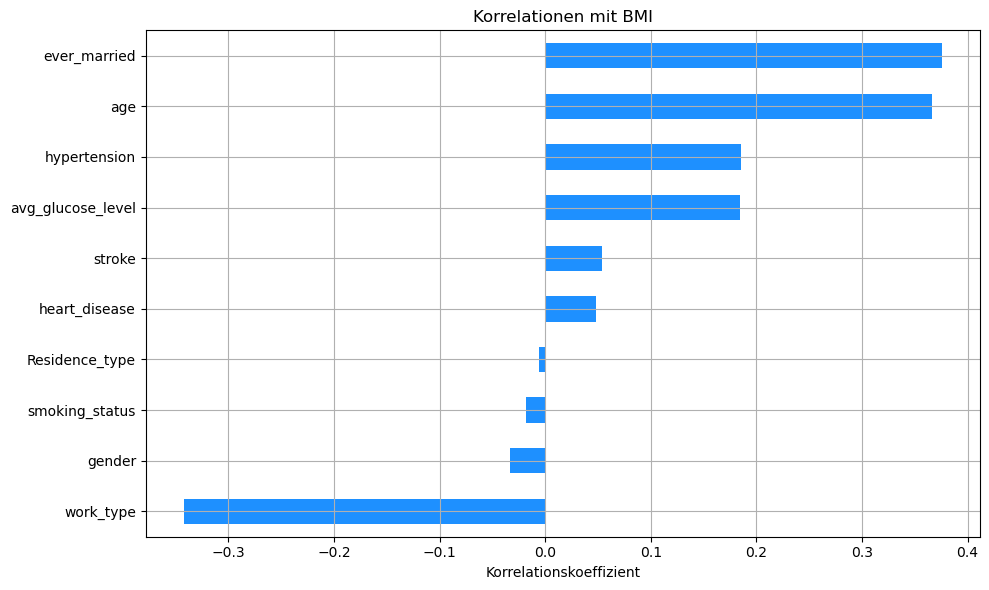

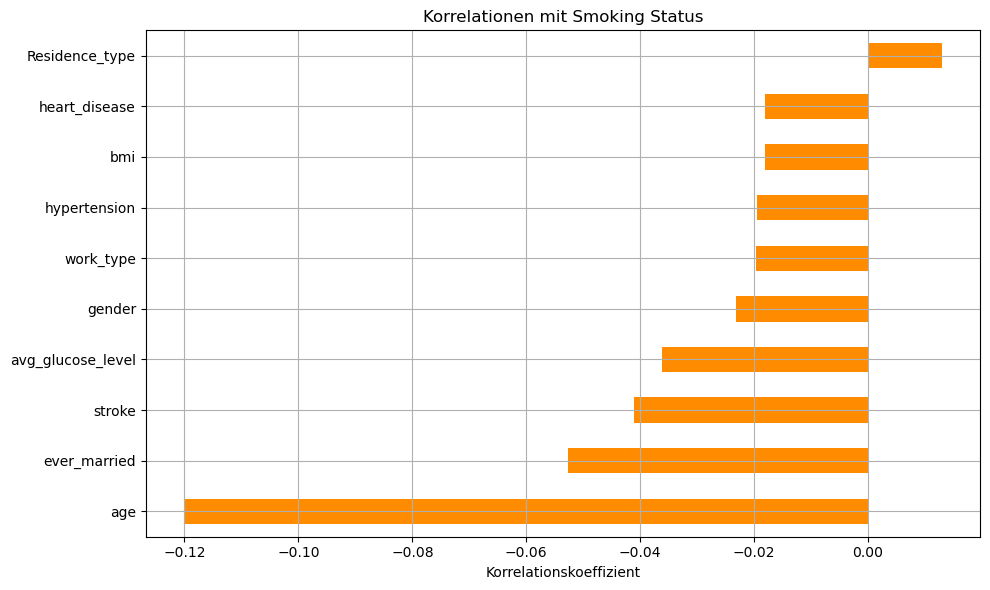

In [30]:
%matplotlib inline

# 1. DataFrame vorbereiten: keine 'id', keine 'Unknown'
df_corr_ord = df_upd[df_upd['smoking_status'] != 'Unknown'].copy()

# 2. Kategoriale Spalten encoden
categorical_cols = df_corr_ord.select_dtypes(include=['object']).columns
oe = OrdinalEncoder()
df_corr_ord[categorical_cols] = oe.fit_transform(df_corr_ord[categorical_cols].astype(str))

# 3. Skalieren (optional aber sinnvoll für Korrelation)
scaler = MinMaxScaler()
df_corr_ord[df_corr_ord.columns] = scaler.fit_transform(df_corr_ord)

# 4. Korrelationsmatrix berechnen
corr_ord = df_corr_ord.corr()

# 5. Korrelationen mit BMI
bmi_corr_sorted = corr_ord['bmi'].drop('bmi').sort_values(ascending=False)

# 6. Korrelationen mit smoking_status
smoking_corr_sorted = corr_ord['smoking_status'].drop('smoking_status').sort_values(ascending=False)

# 7. Plot: BMI
plt.figure(figsize=(10, 6))
bmi_corr_sorted.plot(kind='barh', color='dodgerblue')
plt.title('Korrelationen mit BMI')
plt.xlabel('Korrelationskoeffizient')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Plot: Smoking Status
plt.figure(figsize=(10, 6))
smoking_corr_sorted.plot(kind='barh', color='darkorange')
plt.title('Korrelationen mit Smoking Status')
plt.xlabel('Korrelationskoeffizient')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

#### KNN Regressor für BMI

In [31]:
# 1. Vorbereitung:
# Aufteilen in bekannte vs. fehlende BMI-Werte
df_known = df_upd[df_upd['bmi'].notnull()].copy()
df_missing = df_upd[df_upd['bmi'].isnull()].copy()


# 2. Feature-Auswahl (ausschließen: 'stroke', 'bmi')
features = ['age', 'ever_married', 'work_type', 'hypertension','avg_glucose_level']

categorical_features = ['ever_married', 'work_type',  'hypertension']
numerical_features = ['age', 'avg_glucose_level']

# 3. OneHot-Encoding für kategoriale Features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Für bekannte Daten
encoded_known = ohe.fit_transform(df_known[categorical_features])
encoded_known_df = pd.DataFrame(encoded_known, columns=ohe.get_feature_names_out(categorical_features), index=df_known.index)

# Für fehlende Daten
encoded_missing = ohe.transform(df_missing[categorical_features])
encoded_missing_df = pd.DataFrame(encoded_missing, columns=ohe.get_feature_names_out(categorical_features), index=df_missing.index)

# 4. Numerische Features extrahieren
numerical_known = df_known[numerical_features]
numerical_missing = df_missing[numerical_features]

# 5. Merkmale zusammenfügen
X_known = pd.concat([numerical_known, encoded_known_df], axis=1)
X_missing = pd.concat([numerical_missing, encoded_missing_df], axis=1)

# 6. Skalierung
scaler = MinMaxScaler()
X_known_scaled = scaler.fit_transform(X_known)
X_missing_scaled = scaler.transform(X_missing)

# 7. Modell aufbauen und trainieren (Regression!)
knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_reg.fit(X_known_scaled, df_known['bmi'])

# 8. Vorhersage für fehlende BMI-Werte
pred_bmi = knn_reg.predict(X_missing_scaled)

# 9. Werte einsetzen
df_missing['bmi'] = pred_bmi

# 10. Wieder zusammenführen
df_final = pd.concat([df_known, df_missing], axis=0).sort_index()

# 11. Kontrolle
print("\n✅ BMI-Imputation abgeschlossen!")
print("Noch fehlende BMI-Werte:", df_final['bmi'].isnull().sum())



✅ BMI-Imputation abgeschlossen!
Noch fehlende BMI-Werte: 0


In [32]:
df_final

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,33.699728,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,26.641850,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


#### KNN Classifier für Smoking Status

KNN-Imputer für Smoking-Status, Achtung, im Gegensatz zu BMI korellieren die Features mit "Smoking_Status" nicht eindeutig! Daher werden alle Features verhältnismäßig für das Imputen von "smoking_status" in Betracht gezogen !
s. oben oranges Histogramm

In [33]:
# 1. Vorbereitung
# Annahme: df_upd ist dein aktueller bearbeiteter DataFrame

# Aufteilen: bekannte vs. unbekannte smoking_status
df_known = df_final[df_final['smoking_status'] != 'Unknown'].copy()
df_unknown = df_final[df_final['smoking_status'] == 'Unknown'].copy()

# 2. LabelEncoder auf smoking_status (natürliche Reihenfolge vorhanden!)
le = LabelEncoder()
df_known['smoking_encoded'] = le.fit_transform(df_known['smoking_status'])

# 3. Feature-Auswahl (alles sinnvolle außer 'stroke' wegen Leakage)
features = ['age', 'avg_glucose_level', 'bmi', 'gender', 'ever_married', 'work_type', 'Residence_type', 'hypertension', 'heart_disease']

# 4. OneHot-Encoding für kategoriale Features
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Für bekannte Daten
encoded_known = ohe.fit_transform(df_known[categorical_features])
encoded_known_df = pd.DataFrame(encoded_known, columns=ohe.get_feature_names_out(categorical_features), index=df_known.index)

# Für unbekannte Daten
encoded_unknown = ohe.transform(df_unknown[categorical_features])
encoded_unknown_df = pd.DataFrame(encoded_unknown, columns=ohe.get_feature_names_out(categorical_features), index=df_unknown.index)

# Numerische Features extrahieren
numerical_known = df_known[['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']]
numerical_unknown = df_unknown[['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']]

# Zusammenfügen
X_known = pd.concat([numerical_known, encoded_known_df], axis=1)
X_unknown = pd.concat([numerical_unknown, encoded_unknown_df], axis=1)

# 5. Skalieren (sehr wichtig für KNN!)
scaler = MinMaxScaler()
X_known_scaled = scaler.fit_transform(X_known)
X_unknown_scaled = scaler.transform(X_unknown)

# 6. KNN Modell aufbauen und trainieren
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_known_scaled, df_known['smoking_encoded'])

# 7. Vorhersage für die unbekannten Werte
preds = knn.predict(X_unknown_scaled)
#print(preds)

# 8. Rückübersetzen der Vorhersagen
pred_labels = le.inverse_transform(preds)

# 9. Neue Werte einsetzen
df_unknown['smoking_status'] = pred_labels

# 10. Zusammenführen
df_final = pd.concat([df_known.drop(columns=['smoking_encoded']), df_unknown], axis=0).sort_index()

# 11. Kontrolle
print("\n✅ Imputation abgeschlossen!")
print("Verteilung von smoking_status nach Imputation:")
print(df_final['smoking_status'].value_counts())


✅ Imputation abgeschlossen!
Verteilung von smoking_status nach Imputation:
smoking_status
never smoked       3105
formerly smoked    1071
smokes              933
Name: count, dtype: int64


In [ ]:
df_final.smoking_status.unique()
#keine unknown - smoking status mehr vorhanden

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

In [ ]:
#Prozentsatz der fehlenden Werte (NAs)
df_final.isnull().sum()*100/len(df)

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64

In [ ]:
df_final.to_csv('df_final.csv', index=False)

# RandomForest





# Schritt 1: Zieldefinition & Klassifikator



### Ziel: Wir möchten vorhersagen, ob eine Person einen Schlaganfall (stroke = 1) erleidet oder nicht (stroke = 0) – das ist ein klassisches binäres Klassifikationsproblem.

# Schritt 2: Features & Zielspalte festlegen



### Abschnitt 0: Daten einlesen

In [ ]:
import pandas as pd
df_final = pd.read_csv("df_final.csv")


### Abschnitt 1: Datenvorbereitung (Encoding, Skalierung, Split)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Zielspalte
target = 'stroke'
X = df_final.drop(columns=[target])
y = df_final[target]

# Spalten aufteilen in kategorische und numerische anhand des datentyps (Zahlen vs. Objekt)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore')
X_encoded_sparse = ohe.fit_transform(X[categorical_cols])
X_encoded = pd.DataFrame(X_encoded_sparse.toarray(), columns=ohe.get_feature_names_out(), index=X.index)

# Numerische Features
X_numeric = X[numerical_cols]

# Zusammenführen
X_preprocessed = pd.concat([X_numeric, X_encoded], axis=1)

# Skalierung
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_preprocessed), columns=X_preprocessed.columns, index=X_preprocessed.index)

# Train/Test Split und Stratifizierung!
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### Abschnitt 2: Random Forest (optimierte Baseline)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest mit ausgewogenen Parametern
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=8,
    class_weight='balanced',
    random_state=42
)

# Modelltraining
rf_model.fit(X_train, y_train)

# Vorhersage
y_pred_rf = rf_model.predict(X_test)

### Abschnitt 3: Evaluation – Confusion Matrix & Report

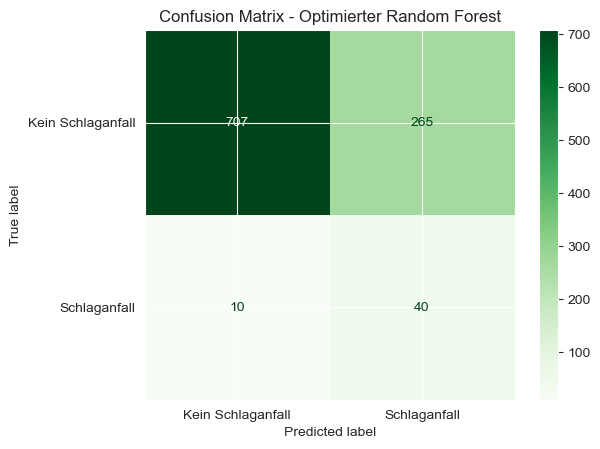

{'0': {'precision': 0.9860529986052998,
  'recall': 0.727366255144033,
  'f1-score': 0.837181764357608,
  'support': 972.0},
 '1': {'precision': 0.13114754098360656,
  'recall': 0.8,
  'f1-score': 0.22535211267605634,
  'support': 50.0},
 'accuracy': 0.7309197651663405,
 'macro avg': {'precision': 0.5586002697944532,
  'recall': 0.7636831275720165,
  'f1-score': 0.5312669385168322,
  'support': 1022.0},
 'weighted avg': {'precision': 0.9442278783694049,
  'recall': 0.7309197651663405,
  'f1-score': 0.8072488068389412,
  'support': 1022.0}}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=["Kein Schlaganfall", "Schlaganfall"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Optimierter Random Forest")
plt.show()

# Bericht
class_report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
class_report_rf

### Abschnitt 4: Cross Validation – Recall & F1 getrennt pro Klasse

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score, precision_score

# Scorer definieren
recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_0 = make_scorer(f1_score, pos_label=0)
f1_1 = make_scorer(f1_score, pos_label=1)

# Cross Validation mit allen Scorern
cv_results = cross_validate(
    rf_model,
    X_train,
    y_train,
    cv=10,
    scoring={
        'recall_0': recall_0,
        'recall_1': recall_1,
        'precision_0': precision_0,
        'precision_1': precision_1,
        'f1_0': f1_0,
        'f1_1': f1_1
    },
    return_train_score=False
)

print("Durchschnittlicher Recall – Kein Schlaganfall (Klasse 0):", round(cv_results['test_recall_0'].mean(), 4))
print(" Durchschnittlicher Recall – Schlaganfall (Klasse 1):     ", round(cv_results['test_recall_1'].mean(), 4))

print("Durchschnittliche Precision – Kein Schlaganfall (Klasse 0):", round(cv_results['test_precision_0'].mean(), 4))
print(" Durchschnittliche Precision – Schlaganfall (Klasse 1):     ", round(cv_results['test_precision_1'].mean(), 4))

print("Durchschnittlicher F1-Score – Kein Schlaganfall (Klasse 0):", round(cv_results['test_f1_0'].mean(), 4))
print(" Durchschnittlicher F1-Score – Schlaganfall (Klasse 1):     ", round(cv_results['test_f1_1'].mean(), 4))


Durchschnittlicher Recall – Kein Schlaganfall (Klasse 0): 0.7382
 Durchschnittlicher Recall – Schlaganfall (Klasse 1):      0.7484
Durchschnittliche Precision – Kein Schlaganfall (Klasse 0): 0.983
 Durchschnittliche Precision – Schlaganfall (Klasse 1):      0.1279
Durchschnittlicher F1-Score – Kein Schlaganfall (Klasse 0): 0.8429
 Durchschnittlicher F1-Score – Schlaganfall (Klasse 1):      0.2182


### Abschnitt 5: GridSearchCV für RandomForest mit Fokus auf Recall

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter-Raster
param_grid = {
    'n_estimators': [10, 15, 25,50,100],
    'max_depth': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [5, 10, 20, 30],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}]
}

f1_klasse1 = make_scorer(f1_score, pos_label=1)

# GridSearchCV Setup
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=f1_klasse1,
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Suche starten (auf Trainingsdaten!)
grid_search.fit(X_train, y_train)

# Beste Parameter anzeigen
print("Beste Parameterkombination:")
print(grid_search.best_params_)

# Bestes Modell speichern
best_rf = grid_search.best_estimator_


Fitting 10 folds for each of 700 candidates, totalling 7000 fits
Beste Parameterkombination:
{'class_weight': {0: 1, 1: 10}, 'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 50}


### Abschnitt 6: Evaluation des besten Random Forest Modells (nach Grid Search)

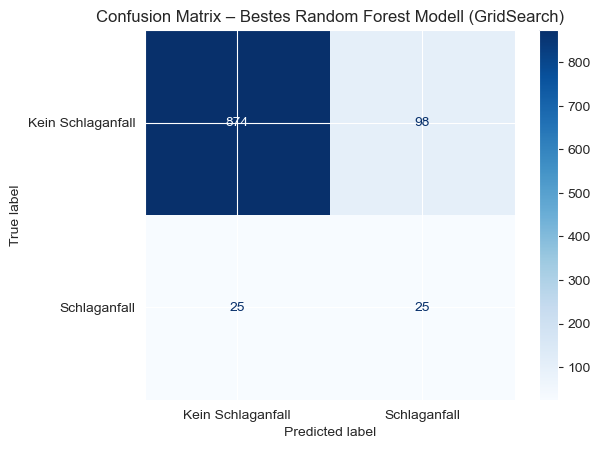

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       972
           1       0.20      0.50      0.29        50

    accuracy                           0.88      1022
   macro avg       0.59      0.70      0.61      1022
weighted avg       0.93      0.88      0.90      1022

Train-Score: 0.8958
Test-Score: 0.8796


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Vorhersage auf Testdaten mit dem besten Modell
y_pred_best = best_rf.predict(X_test)

# Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(conf_matrix_best, display_labels=["Kein Schlaganfall", "Schlaganfall"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Bestes Random Forest Modell (GridSearch)")
plt.show()

# Klassifikationsbericht
report_best = classification_report(y_test, y_pred_best)
print(report_best)

# Train-Score und Test-Score
train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)

print(f"Train-Score: {train_score:.4f}")
print(f"Test-Score: {test_score:.4f}")



### Abschnitt 7: nur Datensatz mit Alter >= 35

In [ ]:
from sklearn.metrics import accuracy_score, precision_score

# Aktualisierten Datensatz laden
df_full = pd.read_csv("df_final.csv")
# Filtere auf Personen ab 35 Jahren
df_filtered = df_full[df_full["age"] >= 35].copy()

# Vorbereitung für erneute Bewertung
X = df_filtered.drop(columns=["stroke"])
# Zielvariable
y = df_filtered["stroke"]


# Kategorische und numerische Spalten identifizieren
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-Hot-Encoding der Kategorischen Spalten
ohe = OneHotEncoder(handle_unknown='ignore')
X_encoded_sparse = ohe.fit_transform(X[categorical_cols])
X_encoded = pd.DataFrame(X_encoded_sparse.toarray(), columns=ohe.get_feature_names_out(), index=X.index)

# Numerische Spalten direkt übernehmen
X_numeric = X[numerical_cols]

# Kombinieren
X_preprocessed = pd.concat([X_numeric, X_encoded], axis=1)

# Normalisieren
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_preprocessed), columns=X_preprocessed.columns, index=X_preprocessed.index)

# Trainings- und Testdaten splitten (mit Stratifizierung)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Initialisiere RandomForest mit festen Parametern
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

# Trainiere das Modell
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Ergebnisse erneut berechnen
results_updated = []
for label in [0, 1]:
    result = {
        "Algorithmus": "RandomForest",
        "CV": 5,
        "y=": label,
        "Train-score": accuracy_score(y_train, y_train_pred),
        "Test-score": accuracy_score(y_test, y_test_pred),
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred, pos_label=label),
        "Recall": recall_score(y_test, y_test_pred, pos_label=label),
        "F1 Score": f1_score(y_test, y_test_pred, pos_label=label)
    }
    results_updated.append(result)

df_rf_updated = pd.DataFrame(results_updated)
print(df_rf_updated)


    Algorithmus  CV  y=  Train-score  Test-score  Accuracy  Precision  \
0  RandomForest   5   0     0.847243    0.796325  0.796325   0.936920   
1  RandomForest   5   1     0.847243    0.796325  0.796325   0.131579   

     Recall  F1 Score  
0  0.836093  0.883640  
1  0.306122  0.184049  


### Abschnitt 8: Vergleich DeepForest - GridSearch - Datensatz => 35 Jahre

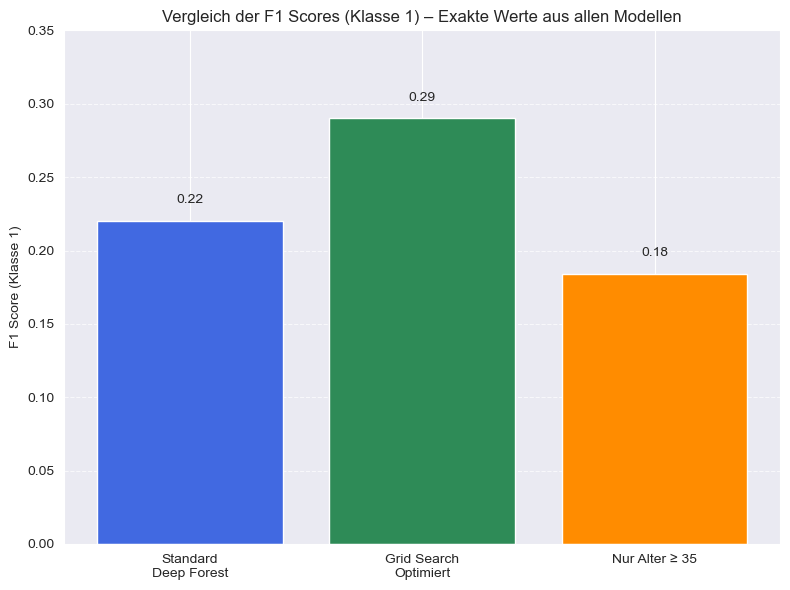

In [ ]:
import matplotlib.pyplot as plt

# Exakte F1-Werte aus deinen echten Ergebnissen (Screenshots)
exact_f1_scores = {
    "Standard\nDeep Forest": 0.22,           # aus Bild 2
    "Grid Search\nOptimiert": 0.29,        # aus Bild 3
    "Nur Alter ≥ 35": 0.184                  # aus Bild 1
}

# Balkendiagramm mit exakten Werten
plt.figure(figsize=(8, 6))
bars = plt.bar(exact_f1_scores.keys(), exact_f1_scores.values(), color=['royalblue', 'seagreen', 'darkorange'])

plt.ylabel("F1 Score (Klasse 1)")
plt.title("Vergleich der F1 Scores (Klasse 1) – Exakte Werte aus allen Modellen")
plt.ylim(0, 0.35)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Werte auf Balken anzeigen
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

